# Filtering the predictions 

#### Distance between complexes filtering
The results issued from prediction and selection python files. The selection file selected compounds from the **top (resp. worst) 100000 complexes** predicted (ordered by ucb), filtered by a **minimal tanimoto distance between 2 compounds of 0.3**.

#### Scaffolds filtering
For each scaffold, there is maximum 10 selected complexes. Once 10 complexes with the same scaffold have been selected, we automatically pass the other complexes that share the said scaffold. 

The corresponding files are *best_complexes_desc.csv* (0.3 distance cutoff) and *worst_complexes_desc.csv* (0.2 distance cutoff).

In [19]:
from random import sample, seed
import numpy as np 
import pandas as pd

#utility functions : prepare the data 
from model_fp_selection.lib.utils import get_morgan_fp, get_rdkit_fp, convert_to_float, get_rdkit_fp_from_smiles
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates, calc_desc
from model_fp_selection.lib.utils import tanimoto_distance, get_distances, get_minimal_distances_dataset, get_mean_distances_dataset


# RDkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs, Draw, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdDepictor import Compute2DCoords

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import mols2grid
import requests
import os

# Combinatorial library generation
import itertools
from itertools import combinations_with_replacement

from tqdm.auto import tqdm
import time

np.random.seed(42)
seed(42)

RDLogger.DisableLog('rdApp.*')

from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

Importing the result files. The *best_complexes_fp* and *worst_complexes_fp* were obtained by passing *best_complexes_desc.csv* and *worst_complexes_desc.csv* into the prediction.py script, and getting the fingerprint predictions. 

In [2]:
best_desc = pd.read_csv('./best_complexes_desc_0.3.csv')
worst_desc = pd.read_csv('./worst_complexes_desc.csv')

In [3]:
best_fp = pd.read_csv('./best_complexes_fp_0.3.csv')
worst_fp = pd.read_csv('./worst_complexes_fp.csv')

Getting the **Morgan Fingerprint for the desc files** (they come from the Descriptors method; so the result file doesn't containg the Morgan Fingerprints), and the **Descriptors for the fp files**.

In [4]:
#L1
best_desc['FP1'] = best_desc['L1'].apply(Chem.MolFromSmiles)
best_desc['FP1'] = best_desc['FP1'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_desc['FP1'] = worst_desc['L1'].apply(Chem.MolFromSmiles)
worst_desc['FP1'] = worst_desc['FP1'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
#L2
best_desc['FP2'] = best_desc['L2'].apply(Chem.MolFromSmiles)
best_desc['FP2'] = best_desc['FP2'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_desc['FP2'] = worst_desc['L2'].apply(Chem.MolFromSmiles)
worst_desc['FP2'] = worst_desc['FP2'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
#L3
best_desc['FP3'] = best_desc['L3'].apply(Chem.MolFromSmiles)
best_desc['FP3'] = best_desc['FP3'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_desc['FP3'] = worst_desc['L3'].apply(Chem.MolFromSmiles)
worst_desc['FP3'] = worst_desc['FP3'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))

In [5]:
best_desc['Fingerprint'] = best_desc['FP1'] + best_desc['FP2'] + best_desc['FP3']
worst_desc['Fingerprint'] = worst_desc['FP1'] + worst_desc['FP2'] + worst_desc['FP3']

In [6]:
best_fp['FP1'] = best_fp.L1.apply(Chem.MolFromSmiles)
best_fp['FP2'] = best_fp.L2.apply(Chem.MolFromSmiles)
best_fp['FP3'] = best_fp.L3.apply(Chem.MolFromSmiles)

best_fp['FP1'] = best_fp['FP1'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
best_fp['FP2'] = best_fp['FP2'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
best_fp['FP3'] = best_fp['FP3'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
best_fp['Fingerprint'] = best_fp['FP1'] + best_fp['FP2'] + best_fp['FP3']

In [7]:
worst_fp['FP1'] = worst_fp.L1.apply(Chem.MolFromSmiles)
worst_fp['FP2'] = worst_fp.L2.apply(Chem.MolFromSmiles)
worst_fp['FP3'] = worst_fp.L3.apply(Chem.MolFromSmiles)

worst_fp['FP1'] = worst_fp['FP1'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_fp['FP2'] = worst_fp['FP2'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_fp['FP3'] = worst_fp['FP3'].apply(lambda mol: get_rdkit_fp(mol, nbits=2048))
worst_fp['Fingerprint'] = worst_fp['FP1'] + worst_fp['FP2'] + worst_fp['FP3']

### Distance to the original dataset

In [8]:
metals = pd.read_csv('ruthenium_complexes_dataset.csv')
metals = prepare_df_rdkit(metals)
metals

L1  \
0         C[N+](C)(C)Cc1ccnc(-c2cc(C[N+](C)(C)C)ccn2)c1   
1     CC[N+](CC)(CC)Cc1ccnc(-c2cc(C[N+](CC)(CC)CC)cc...   
2     CCCC[N+](CCCC)(CCCC)Cc1ccnc(-c2cc(C[N+](CCCC)(...   
3            c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1   
4            c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1   
...                                                 ...   
2966                                c1ccc(-c2ccccn2)nc1   
2967                                c1ccc(-c2ccccn2)nc1   
2968                                c1ccc(-c2ccccn2)nc1   
2969                                c1ccc(-c2ccccn2)nc1   
2970                                c1ccc(-c2ccccn2)nc1   

                                                     L2  \
0         C[N+](C)(C)Cc1ccnc(-c2cc(C[N+](C)(C)C)ccn2)c1   
1     CC[N+](CC)(CC)Cc1ccnc(-c2cc(C[N+](CC)(CC)CC)cc...   
2     CCCC[N+](CCCC)(CCCC)Cc1ccnc(-c2cc(C[N+](CCCC)(...   
3            c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1   
4            c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1   
...                                                 ...   
2966                                c1ccc(-c2ccccn2)nc1   
2967                                c1ccc(-c2ccccn2)nc1   
2968                                c1ccc(-c2ccccn2)nc1   
2969                                c1ccc(-c2ccccn2)nc1   
2970                                c1ccc(-c2ccccn2)nc1   

                                                     L3  Charge  \
0         C[N+](C)(C)Cc1ccnc(-c2cc(C[N+](C)(C)C)ccn2)c1       8   
1     CC[N+](CC)(CC)Cc1ccnc(-c2cc(C[N+](CC)(CC)CC)cc...       8   
2     CCCC[N+](CCCC)(CCCC)Cc1ccnc(-c2cc(C[N+](CCCC)(...       8   
3                   Cc1ccnc(-c2cc(C(=O)NCCCCCCN)ccn2)c1       2   
4                   Cc1ccnc(-c2cc(C(=O)NCCCCCCN)ccn2)c1       2   
...                                                 ...     ...   
2966      C(#Cc1ccc2nc3c4cccnc4c4ncccc4c3nc2c1)c1ccccc1       2   
2967      C(#Cc1ccc2nc3c4cccnc4c4ncccc4c3nc2c1)c1ccccc1       2   
2968      C(#Cc1ccc2nc3c4cccnc4c4ncccc4c3nc2c1)c1ccccc1       2   
2969      C(#Cc1ccc2nc3c4cccnc4c4ncccc4c3nc2c1)c1ccccc1       2   
2970      C(#Cc1ccc2nc3c4cccnc4c4ncccc4c3nc2c1)c1ccccc1       2   

                             DOI   logP       Cells     Localisation  \
0         10.1002/anie.201507800  -3.54        HeLa          lysosom   
1         10.1002/anie.201507800  -3.05        HeLa          lysosom   
2         10.1002/anie.201507800  -1.55        HeLa          lysosom   
3         10.1002/anie.201916400    NaN        HeLa  golgi apparatus   
4         10.1002/anie.201916400    NaN       RPE-1  golgi apparatus   
...                          ...    ...         ...              ...   
2966  10.1016/j.csbj.2018.11.010  -0.87  MDA-MB-231          nucleus   
2967  10.1016/j.csbj.2018.11.010  -0.87        A549          nucleus   
2968  10.1016/j.csbj.2018.11.010  -0.87       MCF.7          nucleus   
2969  10.1016/j.csbj.2018.11.010  -0.87       HepG2          nucleus   
2970  10.1016/j.csbj.2018.11.010  -0.87       HaCat          nucleus   

      IncubationTime    IC50  ...  \
0                4.0  470.00  ...   
1                4.0  425.00  ...   
2                4.0  301.00  ...   
3                4.0   13.57  ...   
4                4.0    4.22  ...   
...              ...     ...  ...   
2966            72.0   17.20  ...   
2967            72.0   20.00  ...   
2968            72.0   74.90  ...   
2969            72.0    9.75  ...   
2970            72.0   47.20  ...   

                                                   MOL3  \
0     <rdkit.Chem.rdchem.Mol object at 0x000001C972B...   
1     <rdkit.Chem.rdchem.Mol object at 0x000001C972B...   
2     <rdkit.Chem.rdchem.Mol object at 0x000001C972B...   
3     <rdkit.Chem.rdchem.Mol object at 0x000001C972B...   
4     <rdkit.Chem.rdchem.Mol object at 0x000001C972B...   
...                                                 ...   
2966  <rdkit.Chem.rdchem.Mol object at 0x000001C972C...   
2967  <rdkit.Chem.rdchem.Mol object at 0x000001C

In [9]:
metals['Fingerprint'] = metals.Fingerprint.apply(np.array)

In [10]:
best_min_dist = get_minimal_distances_dataset(best_desc, metals, tanimoto_distance)
worst_min_dist = get_minimal_distances_dataset(worst_desc, metals, tanimoto_distance)

In [11]:
best_desc['min_dist'] = np.array(best_min_dist)
worst_desc['min_dist'] = np.array(worst_min_dist)

In [12]:
best_mean_dist = get_mean_distances_dataset(best_desc, metals, tanimoto_distance)
worst_mean_dist = get_mean_distances_dataset(worst_desc, metals, tanimoto_distance)

In [13]:
best_desc['mean_dist'] = np.array(best_mean_dist)
worst_desc['mean_dist'] = np.array(worst_mean_dist)

### Adding fingerprint prediction

In [14]:
#best_fp.drop(['prediction 8026', 'variance 8026', 'ucb 8026'], axis=1, inplace=True)

In [15]:
def add_fp_preds(best_desc, best_fp):
    pred_fp = []
    variance_fp = []
    ucb_fp = []
    for fp1 in best_desc.Fingerprint.values.tolist():
        for i, row in best_fp.iterrows():
            if tanimoto_distance(fp1, row['Fingerprint']) == 0:
                pred = row['prediction 1533']
                var = row['variance 1533']
                ucb = row['ucb 1533']
                pred_fp.append(pred)
                variance_fp.append(var)
                ucb_fp.append(ucb)

    best_desc['pred_fp'] = np.array(pred_fp)
    best_desc['variance_fp'] = np.array(variance_fp)
    best_desc['ucb_fp'] = np.array(ucb_fp)
    
    return best_desc

In [16]:
best_desc = add_fp_preds(best_desc, best_fp)
worst_desc = add_fp_preds(worst_desc, worst_fp)

In [17]:
best_desc

L1                        L2  \
0   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
1   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
3   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
4   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
5   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
6   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
7   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
8   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
9   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
10  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
11  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
12    c1cnc2c(c1)ccc1cccnc12    c1cnc2c(c1)ccc1cccnc12   
13  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
14  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
15  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
16  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
17  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
18  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
19  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
20  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
21  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
22  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
23  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
24  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
25       c1ccc(-c2ccccn2)nc1       c1ccc(-c2ccccn2)nc1   
26  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
27  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
28   Cc1ccnc(-c2cc(C)ccn2)c1   Cc1ccnc(-c2cc(C)ccn2)c1   
29  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
30  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
31  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
32  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
33  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
34  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
35  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
36  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
37  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
38  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
39  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
40  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
41  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
42  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
43    c1cnc2c(c1)ccc1cccnc12    c1cnc2c(c1)ccc1cccnc12   
44  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
45  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
46  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   

                                                   L3  \
0                              Oc1cc(I)c(Cl)c2cccnc12   
1                      CC1=Nn2c(nc3ccc(Br)cc3c2=O)SC1   
2                       Cc1cc(Br)c2c(C)c(C)c(C)nc2c1O   
3                         CC1CC(Br)=NN1c1ncc(Cl)cc1Cl   
4                            Oc1ccc(CCl)c2ccc[nH+]c12   
5                      CCOC(=O)C1CN(c2ncccc2Cl)N=C1Br   
6                         O=C1C2CSCC2=NN1c1ccc(Br)cn1   
7                       OC1(C(F)(F)F)CC=NN1c1ncccc1Cl   
8          Cc1nc2ccc(I)cc2c(=O)n1/N=C/c1cc(I)cc(I)c1O   
9                             Cc1cc(Br)cnc1N1N=CCC1=O   
10  CCOc1cc(C=Nn2c(C(C)(C)C)nc3ccc(Br)cc3c2=O)c(Br...   
11                           Cc1cccc(C2=NNC(C)C2Cl)n1   
12      COc1cc(/C=N/n2c(-c3ccccc3)nc3ccccc3c2=O)ccc1O   
13                    CCO/C(C)=N/n1cnc2ccc(Cl)cc2c1=O   
14                             NC1=NN(c2ccc(I)cn2)CC1   
15                       O=C1CC(C2CCC2)=NN1c1ncccc1Br   
16                     CC/C(C)=N/n1c(SC)nc2ccccc2c1=O   
17  COc1cc(/C=N/n2c(-c3ccccc3)nc3c(Br)cc(Br)cc3c2=...   
18                               CC1CC=NN1c1ccc(O)cn1   
19                         COC1Cc2ccnc3c(O)ccc(c23)O1   
20                               S=C1CC(c2cc

### Filtering the data : minimal distance to the dataset

We filter the data by keeping only compounds far enough from the existing compounds of the dataset. 

In [18]:
print(len(best_desc), len(worst_desc))

47 83


In [19]:
filtered_best_desc = best_desc[best_desc['min_dist'] >= 0.15]
filtered_worst_desc = worst_desc[worst_desc['min_dist'] >= 0.15]

In [20]:
print(len(filtered_best_desc), len(filtered_worst_desc))

39 73


### Adding the best and worst examples found in the dataset with the same scaffold

The following scaffolds are the ones that were used for the B ligand generation. 

In [21]:
# SMARTS query for quinoleine framework
quinoleine = Chem.MolFromSmarts('c1cc2c(c([O])c1)[n]ccc2')
#dimequinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])c([CH3])1)[n]c([CH3])cc2')

# SMARTS query for dipyridylamine framework
dipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccccn2)nc1')
#dimedipyamine = Chem.MolFromSmarts('c1ccc(Nc2cccc([CH3])n2)nc([CH3])1')

# SMARTS query for 3-[(Z)-benzylideneamino]-2-phenylquinazolin-4-one framework
framework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2ccccc21')
#meframework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2cccc([CH3])c21')

framework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)ncccc1')
#meframework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)nc([CH3])ccc1')

framework5 = Chem.MolFromSmarts('C1(c2ncccc2)=NNCC1')
#meframework5 = Chem.MolFromSmarts('C1(c2nc([CH3])ccc2)=NNCC1')

framework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)ncccc1')
#meframework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)nc([CH3])ccc1')

framework7 = Chem.MolFromSmarts('C2=NC(c3ccccn3)N=N2')
#meframework7 = Chem.MolFromSmarts('C2=NC(c3cccc([CH3])n3)N=N2')

framework8 = Chem.MolFromSmarts('c1(N2N=CCC2)ncccc1')
#meframework8 = Chem.MolFromSmarts('c1(N2N=CCC2)nc([CH3])ccc1')
bipy = Chem.MolFromSmarts('c1ccc[n]c1-c2[n]cccc2')
phen= Chem.MolFromSmarts('c1c[n]c2c(c1)ccc1ccc[n]c12')


# To include to increase the search space drastically
framework9 = Chem.MolFromSmarts('n1(c2ncccc2)nccc1')
#meframework9 = Chem.MolFromSmarts('n1(c2nc([CH3])ccc2)nccc1')


substructures = [quinoleine, dipyamine, framework3, framework4, framework5, 
                 framework6, framework7, framework8, bipy, phen, framework9] # meframework9] 
substructure_names = ["quinoleine", "dipyamine", "framework3", "framework4", "framework5", 
                          "framework6", "framework7", "framework8", "bipy", "phen", "framework9"]   
    
mols2grid.display(substructures)

MolGridWidget()

In [22]:
scaffold_stats = {}
for sub in substructures:
    sub_smi = Chem.MolToSmiles(sub)
    scaffold_stats[sub_smi] = []

In [23]:
for i, row in metals.iterrows():
    smi = row['L3']
    mol = Chem.MolFromSmiles(smi)
    for sub in substructures:
        if mol.HasSubstructMatch(sub):
            sub_smi = Chem.MolToSmiles(sub)
            scaffold_stats[sub_smi].append(row['pIC50'])

In [24]:
def add_scaffold_stats(df):
    
    best = []
    worst = []
    scaffold = []
    for i, row in df.iterrows():
        smi = row['L3']
        mol = Chem.MolFromSmiles(smi)
        match = False
        for sub_name, sub in zip(substructure_names, substructures):
            if match:
                continue
            if mol.HasSubstructMatch(sub):
                match = True
                sub_smi = Chem.MolToSmiles(sub)
                pic50_list = scaffold_stats[sub_smi]
                best.append(round(max(pic50_list), 2))
                worst.append(round(min(pic50_list), 2))
                scaffold.append(sub_name)
        if not match :
            best.append('no match')
            worst.append('no match')
            scaffold.append('no match')

        #print(best)
    df['scaffold'] = np.array(scaffold)
    df['best_scaffold_example'] = np.array(best)
    df['worst_scaffold_example'] = np.array(worst)
    df['scaffold_type'] = df['scaffold']
    return df

In [25]:
filtered_best_desc = add_scaffold_stats(filtered_best_desc)
filtered_worst_desc = add_scaffold_stats(filtered_worst_desc)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_29400\609779303.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = np.array(scaffold)
C:\Users\CTMguest\AppData\Local\Temp\ipykernel_29400\609779303.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['best_scaffold_example'] = np.array(best)
C:\Users\CTMguest\AppData\Local\Temp\ipykernel_29400\609779303.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [26]:
filtered_best_desc['scaffold']

1     framework3
3     framework8
5     framework8
6     framework8
7     framework8
8     framework3
9     framework8
10    framework3
11    framework5
13    framework3
14    framework8
15    framework8
16    framework3
17    framework3
18    framework8
19    quinoleine
21    framework8
22    framework8
23    framework3
24    framework3
27    framework7
28    quinoleine
29    framework7
30    framework5
31    quinoleine
32    quinoleine
34    quinoleine
35    quinoleine
36    quinoleine
37    framework5
38    framework5
39    framework5
40    framework5
41    framework5
42    framework7
43    framework5
44    framework7
45    framework7
46    framework7
Name: scaffold, dtype: object

In [27]:
def filter_out_macromolecules(df, threshold):
    df['Mol_wt'] = df['L3'].apply(Chem.MolFromSmiles)
    df['Mol_wt'] = df['Mol_wt'].apply(Chem.Descriptors.MolWt)
    return df[df['Mol_wt'] <= threshold]

In [28]:
filtered_worst_desc = filter_out_macromolecules(filtered_worst_desc, 500)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_29400\2601894852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mol_wt'] = df['L3'].apply(Chem.MolFromSmiles)
C:\Users\CTMguest\AppData\Local\Temp\ipykernel_29400\2601894852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mol_wt'] = df['Mol_wt'].apply(Chem.Descriptors.MolWt)


### Displaying molecules and relevant information

In [29]:
#subset = ['ucb_desc','pred_desc', 'min_dist', 'mean_dist']
subset = ['ucb_desc', 'ucb_fp', 'pred_desc', 'pred_fp', 'min_dist', 'mean_dist', 'scaffold_type', 'best_scaffold_example', 'worst_scaffold_example']

In [30]:
def prepare_display(filtered_desc):
    # Rename columns
    desc_display = filtered_desc.rename(columns={'prediction 1533': 'pred_desc', 'variance 1533': 'variance_desc', 'ucb 1533': 'ucb_desc'})
    
    # Combine SMILES
    desc_display['SMILES'] = desc_display['L1'] + '.' + desc_display['L2'] + '.' + desc_display['L3']
    
    # Convert SMILES to RDKit molecules
    desc_display['mol'] = desc_display['SMILES'].apply(Chem.MolFromSmiles)
    
    # Round float columns
    float_columns = desc_display.select_dtypes(include=['float']).columns
    for col in float_columns:
        desc_display[col] = desc_display[col].round(2)
    
    # Format other columns
    for col in subset:
        desc_display[col] = desc_display[col].apply(lambda x: f"{col}: {x}")
    
    return desc_display


In [31]:
best_desc_display = prepare_display(filtered_best_desc)
worst_desc_display = prepare_display(filtered_worst_desc)

In [32]:
mols2grid.display(best_desc_display, mol_col='mol', subset=subset, size=(300,300))

MolGridWidget()

In [33]:
mols2grid.display(worst_desc_display, mol_col='mol', subset=subset, size=(300,300))

MolGridWidget()

Saving the results :

In [34]:
mols2grid.save(best_desc_display, mol_col='mol', subset=subset, size=(300,300), output="1M_best_results_grid.html")
mols2grid.save(worst_desc_display, mol_col='mol', subset=subset, size=(300,300), output="1M_worst_results_grid.html")

MolGridWidget()

MolGridWidget()

In [35]:
def display_best_worst(best_df, worst_df, subset):
        
    grid_best = mols2grid.MolGrid(best_df, subset=subset, name=f'Best results all scaffolds', size=(300,300))
    grid_worst = mols2grid.MolGrid(worst_df, subset=subset, name=f'Worst results for all scaffolds', size=(300,300))

    display(HTML(f"<h2>Best results for all scaffolds</h2>"))
    display(grid_best.display(subset=subset))

    display(HTML(f"<h2>Worst results for all scaffolds</h2>"))
    display(grid_worst.display(subset=subset))

In [36]:
display_best_worst(best_desc_display, worst_desc_display, subset)

MolGridWidget(grid_id='Best results all scaffolds')

MolGridWidget(grid_id='Worst results for all scaffolds')

In [37]:
def save_best_worst(best_df, worst_df, subset):
    
    grid_best = mols2grid.MolGrid(best_df, subset=subset, name=f'Best results all scaffolds', size=(300,300))
    grid_worst = mols2grid.MolGrid(worst_df, subset=subset, name=f'Worst results for all scaffolds', size=(300,300))

    # Create HTML for the titles
    title_best = f"<h3>Best results across the generated library</h3>"
    title_worst = f"<h3>Worst results across the generated library</h3>"
    
    # Generate HTML for grids
    html_best = grid_best.display(subset=subset)._repr_html_()
    html_worst = grid_worst.display(subset=subset)._repr_html_()
    
    # Combine all HTML parts
    full_html = f"""
    <html>
    <head>
        <style>
            body {{
                font-family: Arial, sans-serif;
            }}
            h3 {{
                color: #2c3e50;
            }}
        </style>
    </head>
    <body>
        {title_best}
        {html_best}
        {title_worst}
        {html_worst}
    </body>
    </html>
    """
    
    # Save to HTML file
    with open('1M_prediction_results_best_worst.html', 'w') as f:
        f.write(full_html)

In [38]:
save_best_worst(best_desc_display, worst_desc_display, subset)

MolGridWidget(grid_id='Best results all scaffolds')

MolGridWidget(grid_id='Worst results for all scaffolds')

## Displaying results per scaffold 

In [39]:
substructures = [quinoleine, dipyamine, framework3, framework4, framework5, 
                 framework6, framework7, framework8, bipy, phen, framework9] 
substructure_IUPAC = ["quinoleine", "dipyridineamine", "3-(methyleneamino)quinazolin-4(3H)-one", "2-(1H-pyrazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-3-yl)pyridine", "2-(1H-imidazol-2-yl)pyridine", "2-(3H-1,2,4-triazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-1-yl)pyridine", "bipyridine", "phenanthroline", "2-(1H-pyrazol-1-yl)pyridine"] 
substructure_names = ["quinoleine", "dipyamine", "framework3", "framework4", "framework5", 
                          "framework6", "framework7", "framework8", "bipy", "phen", "framework9"]   

subset_display = ['ucb_desc', 'ucb_fp', 'pred_desc', 'pred_fp', 'min_dist', 'mean_dist', 'best_scaffold_example', 'worst_scaffold_example']

sub_test = [substructures[0], substructure_IUPAC[0], substructure_names[0]]

In [40]:
from IPython.display import display, HTML

def display_best_worst_scaffold(sub_info, best_df, worst_df, subset):

    scaffold_name = sub_info[1]
    scaffold_IUPAC = sub_info[2]
    
    best = best_df[best_df['scaffold'] == scaffold_name]
    worst = worst_df[worst_df['scaffold'] == scaffold_name]
    
    grid_best = mols2grid.MolGrid(best, subset=subset, name=f'Best results for {scaffold_IUPAC}', size=(300,300))
    grid_worst = mols2grid.MolGrid(worst, subset=subset, name=f'Worst results for {scaffold_IUPAC}', size=(300,300))

    display(HTML(f"<h2>Best results for {scaffold_IUPAC} scaffold</h2>"))
    display(grid_best.display(subset=subset))
    
    display(HTML(f"<h2>Worst results for {scaffold_IUPAC} scaffold</h2>"))
    display(grid_worst.display(subset=subset))

In [41]:
display_best_worst_scaffold(sub_test, best_desc_display, worst_desc_display, subset_display)

MolGridWidget(grid_id='Best results for quinoleine')

MolGridWidget(grid_id='Worst results for quinoleine')

In [42]:
def save_best_worst_scaffold(sub_info, best_df, worst_df, subset):

    scaffold_name = sub_info[1]
    scaffold_IUPAC = sub_info[2]
    
    best = best_df[best_df['scaffold'] == scaffold_name]
    worst = worst_df[worst_df['scaffold'] == scaffold_name]
    
    grid_best = mols2grid.MolGrid(best, name=f'Best results for {scaffold_name}', size=(300,300))
    grid_worst = mols2grid.MolGrid(worst, name=f'Worst results for {scaffold_name}', size=(300,300))
    
    # Create HTML for the titles
    title_best = f"<h3>Best results for {scaffold_IUPAC}</h3>"
    title_worst = f"<h3>Worst results for {scaffold_IUPAC}</h3>"
    
    # Generate HTML for grids
    html_best = grid_best.display(subset=subset)._repr_html_()
    html_worst = grid_worst.display(subset=subset)._repr_html_()
    
    # Combine all HTML parts
    full_html = f"""
    <html>
    <head>
        <style>
            body {{
                font-family: Arial, sans-serif;
            }}
            h3 {{
                color: #2c3e50;
            }}
        </style>
    </head>
    <body>
        {title_best}
        {html_best}
        {title_worst}
        {html_worst}
    </body>
    </html>
    """
    
    # Save to HTML file
    with open(f'{scaffold_name}_results_best_worst.html', 'w') as f:
        f.write(full_html)

In [43]:
for i in range(len(substructures)):
    
    sub = substructures[i]
    sub_name = substructure_names[i]
    sub_IUPAC = substructure_IUPAC[i]

    sub_info = [sub, sub_name, sub_IUPAC]
    print(sub)
    save_best_worst_scaffold(sub_info, best_desc_display, worst_desc_display, subset_display)

MolGridWidget(grid_id='Best results for quinoleine')

MolGridWidget(grid_id='Worst results for quinoleine')

MolGridWidget(grid_id='Best results for dipyamine')

MolGridWidget(grid_id='Worst results for dipyamine')

MolGridWidget(grid_id='Best results for framework3')

MolGridWidget(grid_id='Worst results for framework3')

MolGridWidget(grid_id='Best results for framework4')

MolGridWidget(grid_id='Worst results for framework4')

MolGridWidget(grid_id='Best results for framework5')

MolGridWidget(grid_id='Worst results for framework5')

MolGridWidget(grid_id='Best results for framework6')

MolGridWidget(grid_id='Worst results for framework6')

MolGridWidget(grid_id='Best results for framework7')

MolGridWidget(grid_id='Worst results for framework7')

MolGridWidget(grid_id='Best results for framework8')

MolGridWidget(grid_id='Worst results for framework8')

MolGridWidget(grid_id='Best results for bipy')

MolGridWidget(grid_id='Worst results for bipy')

MolGridWidget(grid_id='Best results for phen')

MolGridWidget(grid_id='Worst results for phen')

MolGridWidget(grid_id='Best results for framework9')

MolGridWidget(grid_id='Worst results for framework9')

In [161]:
def best_worst_scaffold(sub_info, best_df, worst_df, subset):

    scaffold_name = sub_info[1]
    scaffold_IUPAC = sub_info[2]
    
    best = best_df[best_df['scaffold'] == scaffold_name]
    worst = worst_df[worst_df['scaffold'] == scaffold_name]
    
    grid_best = mols2grid.MolGrid(best, name=f'Best results for {scaffold_name}', size=(300,300))
    grid_worst = mols2grid.MolGrid(worst, name=f'Worst results for {scaffold_name}', size=(300,300))
    
    # Generate HTML for grids
    html_best = grid_best.display(subset=subset)._repr_html_()
    html_worst = grid_worst.display(subset=subset)._repr_html_()
    
    # Create HTML for the title
    title_best = f"<h3>Best results for {scaffold_IUPAC}</h3>"
    title_worst = f"<h3>Worst results for {scaffold_IUPAC}</h3>"
    
    # Combine HTML parts
    scaffold_html = f"""
    {title_best}
    {html_best}
    {title_worst}
    {html_worst}
    """
    
    return scaffold_html

def generate_combined_html(best_df, worst_df, subset):
    # Generate HTML for each scaffold
    scaffold_htmls = {}
    for i in range(len(substructures)):
        sub = substructures[i]
        sub_name = substructure_names[i]
        sub_IUPAC = substructure_IUPAC[i]

        sub_info = [sub, sub_name, sub_IUPAC]
        
        scaffold_htmls[sub_IUPAC] = best_worst_scaffold(sub_info, best_df, worst_df, subset=subset)
    
    # Generate HTML for tabs
    tabs_html = ""
    for scaffold, html in scaffold_htmls.items():
        tabs_html += f"<button class='tablink' onclick='openTab(\"{scaffold}\")' style='font-size: 16px; padding: 15px 20px;'>{scaffold}</button>\n"

    # Generate JavaScript for tab functionality
    script_html = """
    <script>
    function openTab(tabName) {
        var i, x;
        x = document.getElementsByClassName("scaffold");
        for (i = 0; i < x.length; i++) {
            x[i].style.display = "none";
        }
        document.getElementById(tabName).style.display = "block";
    }
    </script>
    """

    # Combine all HTML parts
    full_html = f"""
    <html>
    <head>
        <style>
            body {{
                font-family: Arial, sans-serif;
            }}
            .tab {{
                
                display: none;
            }}
        </style>
    </head>
    <body>

    {tabs_html}
    
    {script_html}
    
    {"".join([f"<div id='{scaffold}' class='tab scaffold'>{html}</div>" for scaffold, html in scaffold_htmls.items()])}

    </body>
    </html>
    """
    
    return full_html

In [162]:
combined_html = generate_combined_html(best_desc_display, worst_desc_display, subset_display)

MolGridWidget(grid_id='Best results for quinoleine')

MolGridWidget(grid_id='Worst results for quinoleine')

MolGridWidget(grid_id='Best results for dipyamine')

MolGridWidget(grid_id='Worst results for dipyamine')

MolGridWidget(grid_id='Best results for framework3')

MolGridWidget(grid_id='Worst results for framework3')

MolGridWidget(grid_id='Best results for framework4')

MolGridWidget(grid_id='Worst results for framework4')

MolGridWidget(grid_id='Best results for framework5')

MolGridWidget(grid_id='Worst results for framework5')

MolGridWidget(grid_id='Best results for framework6')

MolGridWidget(grid_id='Worst results for framework6')

MolGridWidget(grid_id='Best results for framework7')

MolGridWidget(grid_id='Worst results for framework7')

MolGridWidget(grid_id='Best results for framework8')

MolGridWidget(grid_id='Worst results for framework8')

MolGridWidget(grid_id='Best results for bipy')

MolGridWidget(grid_id='Worst results for bipy')

MolGridWidget(grid_id='Best results for phen')

MolGridWidget(grid_id='Worst results for phen')

MolGridWidget(grid_id='Best results for framework9')

MolGridWidget(grid_id='Worst results for framework9')

In [163]:
# Save to HTML file
with open('1M_best_and_worst_results_by_scaffold.html', 'w') as f:
    f.write(combined_html)

## Refining candidate selection

We will focus on a few scaffolds that seem synthetically (or even commercially) accessible.

In [5]:
# SMARTS query for quinoleine framework
quinoleine = Chem.MolFromSmarts('c1cc2c(c([O])c1)[n]ccc2')
#dimequinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])c([CH3])1)[n]c([CH3])cc2')

# SMARTS query for dipyridylamine framework
dipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccccn2)nc1')
#dimedipyamine = Chem.MolFromSmarts('c1ccc(Nc2cccc([CH3])n2)nc([CH3])1')

# SMARTS query for 3-[(Z)-benzylideneamino]-2-phenylquinazolin-4-one framework
framework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2ccccc21')
#meframework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2cccc([CH3])c21')

framework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)ncccc1')
#meframework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)nc([CH3])ccc1')

framework5 = Chem.MolFromSmarts('C1(c2ncccc2)=NNCC1')
#meframework5 = Chem.MolFromSmarts('C1(c2nc([CH3])ccc2)=NNCC1')

framework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)ncccc1')
#meframework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)nc([CH3])ccc1')

framework7 = Chem.MolFromSmarts('C2=NC(c3ccccn3)N=N2')
#meframework7 = Chem.MolFromSmarts('C2=NC(c3cccc([CH3])n3)N=N2')

framework8 = Chem.MolFromSmarts('c1(N2N=CCC2)ncccc1')
#meframework8 = Chem.MolFromSmarts('c1(N2N=CCC2)nc([CH3])ccc1')
bipy = Chem.MolFromSmarts('c1ccc[n]c1-c2[n]cccc2')
phen= Chem.MolFromSmarts('c1c[n]c2c(c1)ccc1ccc[n]c12')


# To include to increase the search space drastically
framework9 = Chem.MolFromSmarts('n1(c2ncccc2)nccc1')
#meframework9 = Chem.MolFromSmarts('n1(c2nc([CH3])ccc2)nccc1')


substructures = [quinoleine, dipyamine, framework3, framework4, framework5, 
                 framework6, framework7, framework8, bipy, phen, framework9] 
substructure_IUPAC = ["quinoleine", "dipyridineamine", "3-(methyleneamino)quinazolin-4(3H)-one", "2-(1H-pyrazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-3-yl)pyridine", "2-(1H-imidazol-2-yl)pyridine", "2-(3H-1,2,4-triazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-1-yl)pyridine", "bipyridine", "phenanthroline", "2-(1H-pyrazol-1-yl)pyridine"] 
substructure_names = ["quinoleine", "dipyamine", "framework3", "framework4", "framework5", 
                          "framework6", "framework7", "framework8", "bipy", "phen", "framework9"]   

In [7]:
best = pd.read_csv('../100000/best_complexes_100k.csv')


In [8]:
best['MOL3'] = best['L3'].apply(Chem.MolFromSmiles)


In [9]:
worst = pd.read_csv('../100000/worst_complexes_100k.csv')

In [10]:
worst['MOL3'] = worst['L3'].apply(Chem.MolFromSmiles)

In [11]:
def add_scaffold(df):
    scaff = []
    for i,row in df.iterrows():
        mol = row['MOL3']
        match=False
        for sub, name in zip(substructures, substructure_names):
            if mol.HasSubstructMatch(sub) and not match:
                scaff.append(name)
                match=True
        if not match:
            scaff.append('no match')
    df['scaffold'] = np.array(scaff)
    return df

In [12]:
best = add_scaffold(best)

In [13]:
worst = add_scaffold(worst)

### Search for near-commercially available hydroxyquinoline 

In [14]:
best_quin = best[best['scaffold'] == 'quinoleine']

In [15]:
len(best_quin)

2666

In [16]:
worst_quin = worst[worst['scaffold'] == 'quinoleine']

In [17]:
len(worst_quin)

950

In [18]:
worst_quin['FP3'] = worst_quin['MOL3'].apply(get_rdkit_fp)

C:\Users\bparm\AppData\Local\Temp\ipykernel_9744\1082622897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_quin['FP3'] = worst_quin['MOL3'].apply(get_rdkit_fp)


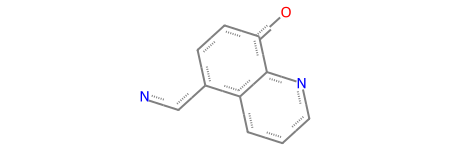

In [93]:
Chem.MolFromSmarts('Oc1ccc(CN)c3cccnc13')

In [94]:
commercial = get_rdkit_fp(Chem.MolFromSmiles('Oc1ccc(CN2CCOCC2)c3cccnc13'))

In [95]:
distance = []
for i in range(len(worst_quin)):
    dist = tanimoto_distance(worst_quin['FP3'].iloc[i], commercial)
    distance.append(dist)

worst_quin['distance_to_commercial'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\1563113715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_quin['distance_to_commercial'] = np.array(distance)


In [96]:
worst_quin.sort_values(by='distance_to_commercial').head(15)

L1                       L2  \
5825       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
22350      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
13773      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
5042       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
12820      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
30576      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
4412       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
25493      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
37318      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
28499  Cc1ccnc(-c2cc(C)ccn2)c1  Cc1ccnc(-c2cc(C)ccn2)c1   
24960      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
20833      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
15559      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
24685      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
28355      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   

                                                      L3  \
5825         C=CCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
22350          Oc1ccc(CNCCCNCc2ccc(O)c3ncccc23)c2cccnc12   
13773         CCCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
5042        CC(C)N(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
12820        C#CCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
30576              Oc1ccc(CNCc2ccc(O)c3ncccc23)c2cccnc12   
4412    Oc1ccc(CN(CCN2CCCC2)Cc2ccc(O)c3ncccc23)c2cccnc12   
25493    Oc1ccc(CN(Cc2ccc(O)c3ncccc23)CC2CCCO2)c2cccnc12   
37318  CC(C)(C)N1CCCN(C(C)(C)C)CCN(Cc2ccc(O)c3ncccc23...   
28499  CC(C)(C)N1CCCN(C(C)(C)C)CCN(Cc2ccc(O)c3ncccc23...   
24960            Oc1ccc(CN(Cc2ccccn2)Cc2ccccn2)c2cccnc12   
20833  CC(C)(C)OC(=O)N1CCCN(C(=O)OC(C)(C)C)CCN(Cc2ccc...   
15559           Oc1ccc(CN2CCN(c3cccc[nH+]3)CC2)c2cccnc12   
24685               Oc1ccc(CN2CCN(c3ccccn3)CC2)c2cccnc12   
28355  CCCN(Cc1ccc(O)c2ncccc12)Cc1ccc(OC(O)N(C)C)c2nc...   

                                             Descriptors  prediction 1533  \
5825   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.109770   
22350  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.067301   
13773  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.095648   
5042   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.118598   
12820  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.099270   
30576  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.038471   
4412   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.120342   
25493  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054612   
37318  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         3.973968   
28499  [ 2.49212365e+00  4.06079647e+02  9.96625533e+...         4.018098   
24960  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054309   
20833  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054713   
15559  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.069980   
24685  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.061788   
28355  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.043149   

       variance 1533  ucb 1533  \
5825        4.914745  6.770076   
22350       4.889619  6.720799   
13773       4.887145  6.748474   
5042        4.889276  6.772003   
12820       4.884232  6.751306   
30576       4.851099  6.681496   
4412        4.888398  6.773509   
25493       4.890370  6.708314   
37318       4.908579  6.632606   
28499       4.972168  6.693901   
24960       4.900321  6.710709   
20833       4.957336  6.726522   
15559       4.962452  6.743167   
24685       4.876641  6.711762   
28355       4.882162  6.694623   

                                                    MOL3    scaffold  \
5825   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...  quinoleine   
22350  <rdkit.Chem.rdchem.Mol object at 0x0000018A968...  quinoleine   
13773  <rdkit.Chem.rdchem.Mol object at 0x0000018AA83...  quinoleine   
5042   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...

In [120]:
mols2grid.display(worst_quin.sort_values(by='distance_to_commercial').head(15), mol_col='MOL3', size=(200,200))

MolGridWidget()

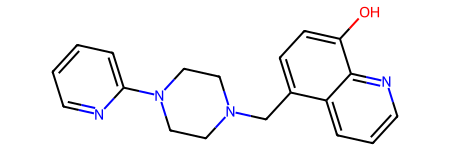

In [122]:
worst_quin['MOL3'][24685]

In [123]:
bad_mol = worst_quin['FP3'][24685]

In [124]:
best_quin['FP3'] = best_quin['MOL3'].apply(get_rdkit_fp)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\3129419496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_quin['FP3'] = best_quin['MOL3'].apply(get_rdkit_fp)


In [125]:
distance = []
for i in range(len(best_quin)):
    dist = tanimoto_distance(best_quin['FP3'].iloc[i], bad_mol)
    distance.append(dist)
    
best_quin['distance_to_bad_mol'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\1718743421.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_quin['distance_to_bad_mol'] = np.array(distance)


In [126]:
best_quin.sort_values(by='distance_to_bad_mol').head(15)

L1                        L2  \
30616  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
67026  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2054   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2558   Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
85727  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
85728  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
31697  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
31698  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
39765  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
39764  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
39763  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
31741  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
55965  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
60659  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
60660  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   

                                                L3  \
30616  Oc1ccc(CN2CCN(c3ccc(F)cc3)CC2)c2ccc[nH+]c12   
67026     Oc1ccc(CN2CCN(c3cccc(Cl)c3)CC2)c2cccnc12   
2054                 Oc1ccc(CN2CC[N-]CC2)c2cccnc12   
2558                    Oc1ccc(CN2CCNCC2)c2cccnc12   
85727        Oc1ccc(CN2CCN(c3ccccc3F)CC2)c2cccnc12   
85728        Oc1ccc(CN2CCN(c3ccccc3F)CC2)c2cccnc12   
31697                CN1CCN(Cc2ccc(O)c3ncccc23)CC1   
31698                CN1CCN(Cc2ccc(O)c3ncccc23)CC1   
39765               CCN1CCN(Cc2ccc(O)c3ncccc23)CC1   
39764               CCN1CCN(Cc2ccc(O)c3ncccc23)CC1   
39763               CCN1CCN(Cc2ccc(O)c3ncccc23)CC1   
31741               CCN(C)CCN(C)Cc1ccc(O)c2ncccc12   
55965             C#CCN1CCN(Cc2ccc(O)c3ncccc23)CC1   
60659              OCCN1CCN(Cc2ccc(O)c3ncccc23)CC1   
60660              OCCN1CCN(Cc2ccc(O)c3ncccc23)CC1   

                                             Descriptors  prediction 1533  \
30616  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.932270   
67026  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.744309   
2054   [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.143793   
2558   [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.105816   
85727  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.699160   
85728  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.699160   
31697  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.813276   
31698  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.813276   
39765  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.786449   
39764  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.786449   
39763  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.786449   
31741  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.820709   
55965  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.708806   
60659  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.687960   
60660  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.687960   

       variance 1533  ucb 1533  \
30616       5.040019  8.626268   
67026       5.373270  8.525947   
2054        5.059935  8.843109   
2558        5.144131  8.827497   
85727       5.413963  8.491311   
85728       5.413963  8.491311   
31697       5.479455  8.622265   
31698       5.479455  8.622265   
39765       5.473722  8.593967   
39764       5.473722  8.593967   
39763       5.473722  8.593967   
31741       5.449892  8.622109   
55965       5.606762  8.550239   
60659       5.647231  8.539628   
60660       5.647231  8.539628   

                                                    MOL3    scaffold  \
30616  <rdkit.Chem.rdchem.Mol object at 0x0000018AA89...  quinoleine   
67026  <rdkit.Chem.rdchem.Mol object at 0x0000018AA7B...  quinoleine   
2054   <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...  quinoleine   
2558   <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...  quinoleine   
85727  <rdkit.Chem.rdchem.Mol object at 0x0000018

In [127]:
mols2grid.display(best_quin.sort_values(by='distance_to_bad_mol').head(15), mol_col='MOL3', size=(200,200))

MolGridWidget()

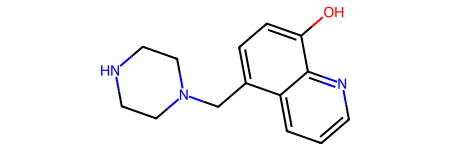

In [132]:
best_quin['MOL3'][2558]

In [128]:
good_mol = best_quin['FP3'][2558]

In [129]:
distance = []
for i in range(len(worst_quin)):
    dist = tanimoto_distance(worst_quin['FP3'].iloc[i], good_mol)
    distance.append(dist)

worst_quin['distance_to_good_mol'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\3638768917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_quin['distance_to_good_mol'] = np.array(distance)


In [130]:
worst_quin.sort_values(by='distance_to_good_mol').head(15)

L1                       L2  \
4412       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
28499  Cc1ccnc(-c2cc(C)ccn2)c1  Cc1ccnc(-c2cc(C)ccn2)c1   
37318      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
5042       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
5825       c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
13773      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
22350      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
12820      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
30576      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
24960      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
15559      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
24685      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
20833      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
25493      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   
28355      c1ccc(-c2ccccn2)nc1      c1ccc(-c2ccccn2)nc1   

                                                      L3  \
4412    Oc1ccc(CN(CCN2CCCC2)Cc2ccc(O)c3ncccc23)c2cccnc12   
28499  CC(C)(C)N1CCCN(C(C)(C)C)CCN(Cc2ccc(O)c3ncccc23...   
37318  CC(C)(C)N1CCCN(C(C)(C)C)CCN(Cc2ccc(O)c3ncccc23...   
5042        CC(C)N(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
5825         C=CCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
13773         CCCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
22350          Oc1ccc(CNCCCNCc2ccc(O)c3ncccc23)c2cccnc12   
12820        C#CCN(Cc1ccc(O)c2ncccc12)Cc1ccc(O)c2ncccc12   
30576              Oc1ccc(CNCc2ccc(O)c3ncccc23)c2cccnc12   
24960            Oc1ccc(CN(Cc2ccccn2)Cc2ccccn2)c2cccnc12   
15559           Oc1ccc(CN2CCN(c3cccc[nH+]3)CC2)c2cccnc12   
24685               Oc1ccc(CN2CCN(c3ccccn3)CC2)c2cccnc12   
20833  CC(C)(C)OC(=O)N1CCCN(C(=O)OC(C)(C)C)CCN(Cc2ccc...   
25493    Oc1ccc(CN(Cc2ccc(O)c3ncccc23)CC2CCCO2)c2cccnc12   
28355  CCCN(Cc1ccc(O)c2ncccc12)Cc1ccc(OC(O)N(C)C)c2nc...   

                                             Descriptors  prediction 1533  \
4412   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.120342   
28499  [ 2.49212365e+00  4.06079647e+02  9.96625533e+...         4.018098   
37318  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         3.973968   
5042   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.118598   
5825   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.109770   
13773  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.095648   
22350  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.067301   
12820  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.099270   
30576  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.038471   
24960  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054309   
15559  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.069980   
24685  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.061788   
20833  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054713   
25493  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.054612   
28355  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.043149   

       variance 1533  ucb 1533  \
4412        4.888398  6.773509   
28499       4.972168  6.693901   
37318       4.908579  6.632606   
5042        4.889276  6.772003   
5825        4.914745  6.770076   
13773       4.887145  6.748474   
22350       4.889619  6.720799   
12820       4.884232  6.751306   
30576       4.851099  6.681496   
24960       4.900321  6.710709   
15559       4.962452  6.743167   
24685       4.876641  6.711762   
20833       4.957336  6.726522   
25493       4.890370  6.708314   
28355       4.882162  6.694623   

                                                    MOL3    scaffold  \
4412   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...  quinoleine   
28499  <rdkit.Chem.rdchem.Mol object at 0x0000018A969...  quinoleine   
37318  <rdkit.Chem.rdchem.Mol object at 0x0000018A96A...  quinoleine   
5042   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...

In [131]:
mols2grid.display(worst_quin.sort_values(by='distance_to_good_mol').head(15), mol_col='MOL3', size=(200,200))

MolGridWidget()

In [179]:
common_columns = best_quin.columns.intersection(worst_quin.columns)

In [191]:
good_quin = best_quin.loc[2558, common_columns]

In [192]:
bad_quin = worst_quin.loc[24685, common_columns]

In [193]:
good_bad_quin = pd.DataFrame(columns=common_columns)

In [195]:
good_bad_quin.loc[0] = good_quin

In [196]:
good_bad_quin.loc[1] = bad_quin

In [307]:
mols2grid.display(good_bad_quin, mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], size=(300,300))

MolGridWidget()

In [309]:
mols2grid.save(good_bad_quin, output='good_bad_examples_quinoline.html', mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], 
               size=(300,300))

MolGridWidget()

### Search for similar methyleneaminoquinazolinone structures with drastically different predictions

In [201]:
best_meth = best[best['scaffold'] == 'framework3']

In [202]:
len(best_meth)

95246

In [203]:
worst_meth = worst[worst['scaffold'] == 'framework3']

In [204]:
len(worst_meth)

22

In [234]:
worst_meth.head(22)

L1                   L2  \
504    c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
505    c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
506    c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
1791   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
1792   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
1793   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
1869   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
2174   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
4893   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
6913   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
7127   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
7128   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
7129   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
7413   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
8428   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
8490   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
13192  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
13193  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
18660  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
18661  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
18759  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
19364  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   

                                                      L3  \
504                    CC(=Nn1c(C)nc2ccccc2c1=O)c1ccncc1   
505                  C/C(=N\n1c(C)nc2ccccc2c1=O)c1ccncc1   
506                  C/C(=N/n1c(C)nc2ccccc2c1=O)c1ccncc1   
1791                    Cc1nc2ccccc2c(=O)n1/N=C/c1ccncc1   
1792                    Cc1nc2ccccc2c(=O)n1/N=C\c1ccncc1   
1793                      Cc1nc2ccccc2c(=O)n1N=Cc1ccncc1   
1869               O=c1c2ccccc2nc(C2CCCCC2)n1N=Cc1ccncc1   
2174   CCOc1cc(/C=N\n2cnc3ccccc3c2=O)ccc1Oc1ccc([N+](...   
4893   COc1cc(C=Nn2c(C3CCCCC3)nc3ccc(Br)cc3c2=O)c(Br)...   
6913   CCOc1cc(C=Nn2c(C3CCCCC3)nc3ccc(Br)cc3c2=O)c(Br...   
7127                 CCCc1nc2ccccc2c(=O)n1N=C(C)c1ccncc1   
7128               CCCc1nc2ccccc2c(=O)n1/N=C(\C)c1ccncc1   
7129               CCCc1nc2ccccc2c(=O)n1/N=C(/C)c1ccncc1   
7413                       O=c1c2ccccc2ncn1/N=C/c1ccncc1   
8428             O=c1c2ccccc2nc(C(F)(F)F)n1/N=C/c1ccncc1   
8490              Cn1cccc1C=Nn1c(-c2ccncc2)nc2ccccc2c1=O   
13192      COc1cc(C=Nn2cnc3ccccc3c2=O)ccc1OC(=O)c1cccnc1   
13193    COc1cc(/C=N/n2cnc3ccccc3c2=O)ccc1OC(=O)c1cccnc1   
18660  COc1cc(/C=N/n2c(C)nc3ccccc3c2=O)ccc1OC(=O)c1cc...   
18661   COc1cc(C=Nn2c(C)nc3ccccc3c2=O)ccc1OC(=O)c1cccnc1   
18759  O=c1c2cc(Br)ccc2nc(C2CCCCC2)n1N=Cc1cc(I)c(Oc2c...   
19364   COc1cc(C=Nn2c(C)nc3ccccc3c2=O)ccc1OC(=O)c1ccncc1   

                                             Descriptors  prediction 1533  \
504    [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.100104   
505    [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.100104   
506    [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.100104   
1791   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.103730   
1792   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.103730   
1793   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.103730   
1869   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.095915   
2174   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.100849   
4893   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.085083   
6913   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.082757   
7127   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.081167   
7128   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.081167   
7129   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.081167   
7413   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.093584   
8428   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.093465   
8490   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.082915   
13192  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.086870   
13193  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.086870   
18660 

In [212]:
mols2grid.display(worst_meth['MOL3'].values.tolist(), size=(200,200))

MolGridWidget()

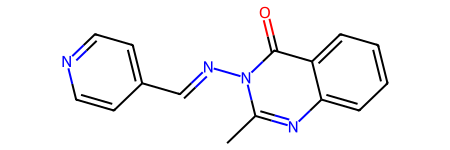

In [217]:
worst_meth['MOL3'][1791]

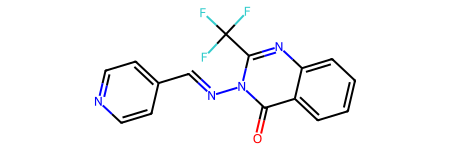

In [215]:
worst_meth['MOL3'][8428]

In [230]:
bad_mol = get_rdkit_fp(worst_meth['MOL3'][8428])

In [226]:
best_meth = best_meth.loc[:10000]

In [228]:
best_meth['FP3'] = best_meth['MOL3'].apply(get_rdkit_fp)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\1831616951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_meth['FP3'] = best_meth['MOL3'].apply(get_rdkit_fp)


In [231]:
distance = []
for i in range(len(best_meth)):
    dist = tanimoto_distance(best_meth['FP3'].iloc[i], bad_mol)
    distance.append(dist)
    
best_meth['distance_to_bad_mol'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\1570916634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_meth['distance_to_bad_mol'] = np.array(distance)


In [232]:
best_meth.sort_values(by='distance_to_bad_mol').head(15)

L1                        L2  \
7566  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
7567  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
7568  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
1530  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2118  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2119  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2120  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
3061  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
3062  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
9738  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
9740  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
9739  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
1088  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2749  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
2748  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   

                                          L3  \
7566          Cc1nc2ccccc2c(=O)n1N=Cc1ccccc1   
7567        Cc1nc2ccccc2c(=O)n1/N=C/c1ccccc1   
7568        Cc1nc2ccccc2c(=O)n1/N=C\c1ccccc1   
1530    Cc1nc2ccccc2c(=O)n1/N=C\c1cccc(Cl)c1   
2118      Cc1nc2ccccc2c(=O)n1N=Cc1ccc(Cl)cc1   
2119    Cc1nc2ccccc2c(=O)n1/N=C/c1ccc(Cl)cc1   
2120    Cc1nc2ccccc2c(=O)n1/N=C\c1ccc(Cl)cc1   
3061     Cc1nc2ccccc2c(=O)n1N=Cc1ccc(C#N)cc1   
3062   Cc1nc2ccccc2c(=O)n1/N=C\c1ccc(C#N)cc1   
9738     Cc1cccc(/C=N/n2c(C)nc3ccccc3c2=O)c1   
9740     Cc1cccc(/C=N\n2c(C)nc3ccccc3c2=O)c1   
9739       Cc1cccc(C=Nn2c(C)nc3ccccc3c2=O)c1   
1088  Cc1nc2ccccc2c(=O)n1N=Cc1cc(Cl)cc(Cl)c1   
2749     Cc1nc2ccccc2c(=O)n1/N=C/c1ccc(F)cc1   
2748       Cc1nc2ccccc2c(=O)n1N=Cc1ccc(F)cc1   

                                            Descriptors  prediction 1533  \
7566  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.092074   
7567  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.092074   
7568  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.092074   
1530  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.205888   
2118  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.178887   
2119  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.178887   
2120  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.178887   
3061  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.094883   
3062  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.094883   
9738  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.085509   
9740  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.085509   
9739  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.085509   
1088  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.204380   
2749  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.132013   
2748  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.132013   

      variance 1533  ucb 1533  \
7566       4.910461  8.751222   
7567       4.910461  8.751222   
7568       4.910461  8.751222   
1530       4.915100  8.866291   
2118       4.921096  8.840912   
2119       4.921096  8.840912   
2120       4.921096  8.840912   
3061       5.134829  8.814102   
3062       5.134829  8.814102   
9738       4.869059  8.733422   
9740       4.869059  8.733422   
9739       4.869059  8.733422   
1088       5.021500  8.893424   
2749       5.025878  8.822230   
2748       5.025878  8.822230   

                                                   MOL3    scaffold  \
7566  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8D...  framework3   
7567  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8D...  framework3   
7568  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8D...  framework3   
1530  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...  framework3   
2118  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...  framework3   
2119  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...  framework3   
2120  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8E...

In [233]:
mols2grid.display(best_meth.sort_values(by='distance_to_bad_mol').head(15), mol_col='MOL3')

MolGridWidget()

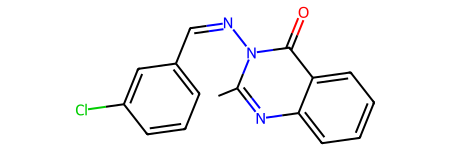

In [235]:
best_meth['MOL3'][1530]

In [236]:
common_columns = best_meth.columns.intersection(worst_meth.columns)

In [237]:
good_bad_meth = pd.DataFrame(columns=common_columns)

In [239]:
good_meth = best_meth.loc[1530, common_columns]

In [240]:
bad_meth = worst_meth.loc[1791, common_columns]

In [241]:
good_bad_meth.loc[0] = good_meth

In [242]:
good_bad_meth.loc[1] = bad_meth

In [243]:
mols2grid.display(good_bad_meth, mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], size=(300,300))

MolGridWidget()

In [310]:
mols2grid.save(good_bad_meth, output='good_bad_examples_framework3.html', mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], 
               size=(300,300))

MolGridWidget()

### Finding a third scaffold for examplification

In [247]:
best_no_match = best[best['scaffold'] == 'no match']

In [248]:
worst_no_match = worst[worst['scaffold'] == 'no match']

In [249]:
len(best_no_match)

2088

In [250]:
len(worst_no_match)

49566

In [251]:
# SMARTS query for quinoleine framework
quinoleine = Chem.MolFromSmarts('c1cc2c(c([O])c1)[n]ccc2')
#dimequinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])c([CH3])1)[n]c([CH3])cc2')

# SMARTS query for dipyridylamine framework
dipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccccn2)nc1')
#dimedipyamine = Chem.MolFromSmarts('c1ccc(Nc2cccc([CH3])n2)nc([CH3])1')

# SMARTS query for 3-[(Z)-benzylideneamino]-2-phenylquinazolin-4-one framework
framework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2ccccc21')
#meframework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2cccc([CH3])c21')

framework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)ncccc1')
#meframework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)nc([CH3])ccc1')

framework5 = Chem.MolFromSmarts('C1(c2ncccc2)=NNCC1')
#meframework5 = Chem.MolFromSmarts('C1(c2nc([CH3])ccc2)=NNCC1')

framework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)ncccc1')
#meframework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)nc([CH3])ccc1')

framework7 = Chem.MolFromSmarts('C2=NC(c3ccccn3)N=N2')
#meframework7 = Chem.MolFromSmarts('C2=NC(c3cccc([CH3])n3)N=N2')

framework8 = Chem.MolFromSmarts('c1(N2N=CCC2)ncccc1')
#meframework8 = Chem.MolFromSmarts('c1(N2N=CCC2)nc([CH3])ccc1')
bipy = Chem.MolFromSmarts('c1ccc[n]c1-c2[n]cccc2')
phen= Chem.MolFromSmarts('c1c[n]c2c(c1)ccc1ccc[n]c12')


# To include to increase the search space drastically
framework9 = Chem.MolFromSmarts('n1(c2ncccc2)nccc1')
#meframework9 = Chem.MolFromSmarts('n1(c2nc([CH3])ccc2)nccc1')


substructures = [quinoleine, dipyamine, framework3, framework4, framework5, 
                 framework6, framework7, framework8, bipy, phen, framework9] 
substructure_IUPAC = ["quinoleine", "dipyridineamine", "3-(methyleneamino)quinazolin-4(3H)-one", "2-(1H-pyrazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-3-yl)pyridine", "2-(1H-imidazol-2-yl)pyridine", "2-(3H-1,2,4-triazol-3-yl)pyridine", 
                      "2-(4,5-dihydro-1H-pyrazol-1-yl)pyridine", "bipyridine", "phenanthroline", "2-(1H-pyrazol-1-yl)pyridine"] 
substructure_names = ["quinoleine", "dipyamine", "framework3", "framework4", "framework5", 
                          "framework6", "framework7", "framework8", "bipy", "phen", "framework9"]   

In [259]:
def add_scaffold_wide(df):
    scaff = []
    for i,row in df.iterrows():
        mol = row['MOL3']
        match=False
        for sub, name in zip(substructures, substructure_names):
            if mol.HasSubstructMatch(sub) and not match:
                scaff.append(name)
                match=True
        if not match:
            scaff.append('no match')
    df['scaffold'] = np.array(scaff)
    return df

In [253]:
best_no_match = add_scaffold_wide(best_no_match)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\490755326.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = np.array(scaff)


In [254]:
value_counts = best_no_match['scaffold'].value_counts()

print(value_counts)

framework8    1092
framework9     778
framework5     198
framework7      19
bipy             1
Name: scaffold, dtype: int64


In [262]:
best_fr9 = best_no_match[best_no_match['scaffold'] == 'framework9']

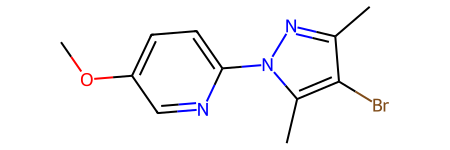

In [265]:
best_fr9['MOL3'][7716]

In [260]:
worst_no_match = add_scaffold_wide(worst_no_match)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\3602408918.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = np.array(scaff)


In [261]:
value_counts = worst_no_match['scaffold'].value_counts()

print(value_counts)

bipy          27455
phen           9036
framework9     6744
dipyamine      4671
framework6     1388
framework5      137
framework8      132
framework7        2
no match          1
Name: scaffold, dtype: int64


In [267]:
worst_fr9 = worst_no_match[worst_no_match['scaffold']=='framework9']

In [271]:
best_fr9['FP3'] = best_fr9['MOL3'].apply(get_rdkit_fp)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\1636805915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_fr9['FP3'] = best_fr9['MOL3'].apply(get_rdkit_fp)


In [272]:
worst_fr9['FP3'] = worst_fr9['MOL3'].apply(get_rdkit_fp)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\2767874370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_fr9['FP3'] = worst_fr9['MOL3'].apply(get_rdkit_fp)


In [290]:
commercial = get_rdkit_fp(Chem.MolFromSmiles('OCc1ccc(nc1)-n2cccn2'))

In [291]:
distance = []
for i in range(len(best_fr9)):
    dist = tanimoto_distance(best_fr9['FP3'].iloc[i], commercial)
    distance.append(dist)
    
best_fr9['distance_to_commercial'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\2709502294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_fr9['distance_to_commercial'] = np.array(distance)


In [292]:
best_fr9.sort_values(by='distance_to_commercial').head(15)

L1                        L2  \
76220  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
70238  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
83487  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
79167  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
79168  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
79166  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
83018  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
82424  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
82422  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
82423  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
67065  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
77812  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
90101  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
72921  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
72814  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   

                                     L3  \
76220           OCc1ccc(-n2cc(F)cn2)nc1   
70238          OCc1ccc(-n2cc(Cl)cn2)nc1   
83487            Cc1ccc(-n2cc(F)cn2)nc1   
79167        CC(O)c1ccc(-n2cc(F)cn2)nc1   
79168   C[C@@H](O)c1ccc(-n2cc(F)cn2)nc1   
79166    C[C@H](O)c1ccc(-n2cc(F)cn2)nc1   
83018           Cc1ccc(-n2cc(Cl)cn2)nc1   
82424       CC(O)c1ccc(-n2cc(Cl)cn2)nc1   
82422  C[C@@H](O)c1ccc(-n2cc(Cl)cn2)nc1   
82423   C[C@H](O)c1ccc(-n2cc(Cl)cn2)nc1   
67065        CCCOc1cnn(-c2ccc(CO)cn2)c1   
77812           CCc1ccc(-n2cc(F)cn2)nc1   
90101           CCc1ccc(-n2cc(N)cn2)nc1   
72921          CCCc1ccc(-n2cc(F)cn2)nc1   
72814         Cc1nn(-c2ccc(CO)cn2)cc1Cl   

                                             Descriptors  prediction 1533  \
76220  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.523929   
70238  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.540210   
83487  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.519445   
79167  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.530733   
79168  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.530733   
79166  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.530733   
83018  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.525378   
82424  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.510753   
82422  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.510753   
82423  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.510753   
67065  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.534574   
77812  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.539092   
90101  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.511815   
72921  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.549416   
72814  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         5.540162   

       variance 1533  ucb 1533  \
76220       6.185605  8.508435   
70238       6.164667  8.519660   
83487       6.149128  8.495137   
79167       6.134313  8.502839   
79168       6.134313  8.502839   
79166       6.134313  8.502839   
83018       6.127974  8.495948   
82424       6.193221  8.497095   
82422       6.193221  8.497095   
82423       6.193221  8.497095   
67065       6.213750  8.525861   
77812       6.110470  8.505416   
90101       6.134949  8.484075   
72921       6.105712  8.514584   
72814       6.144733  8.514791   

                                                    MOL3    scaffold  \
76220  <rdkit.Chem.rdchem.Mol object at 0x0000018A94E...  framework9   
70238  <rdkit.Chem.rdchem.Mol object at 0x0000018AA79...  framework9   
83487  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8D...  framework9   
79167  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8F...  framework9   
79168  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8F...  framework9   
79166  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8F...  framework9   
83018  <rdkit.Chem.rdchem.Mol object at 0x0000018AA8D...  framework9   
82424  <r

In [293]:
mols2grid.display(best_fr9.sort_values(by='distance_to_commercial').head(15), mol_col='MOL3')

MolGridWidget()

In [279]:
good_fr9 = best_fr9['FP3'][83487]

In [281]:
distance = []
for i in range(len(worst_fr9)):
    dist = tanimoto_distance(worst_fr9['FP3'].iloc[i], good_fr9)
    distance.append(dist)
    
worst_fr9['distance_to_good_mol'] = np.array(distance)

C:\Users\CTMguest\AppData\Local\Temp\ipykernel_13732\4094640904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_fr9['distance_to_good_mol'] = np.array(distance)


In [282]:
worst_fr9.sort_values(by='distance_to_good_mol').head(15)

L1                   L2  \
4885   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
13876  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
23084  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
3375   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
25364  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
9094   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
7874   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
26084  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
9887   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
13903  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
1208   c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
12336  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
18874  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
10526  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   
28859  c1ccc(-c2ccccn2)nc1  c1ccc(-c2ccccn2)nc1   

                                                      L3  \
4885                         Cc1cnn(-c2ccc(C(=O)O)cn2)c1   
13876                       Cc1ccn(-c2ccc(CC(=O)O)cn2)n1   
23084        CC(=O)NCc1ccc(C(=O)NCc2ccc(-n3cccn3)nc2)cc1   
3375              CN(Cc1ccc(-n2cc(F)cn2)nc1)c1ccc(Br)cn1   
25364  CC(C)(C)NC(=O)c1ccc(C(=O)NCc2ccc(-n3cccn3)nc2)cc1   
9094                        CCc1cnn(-c2ccc(C(=O)O)cn2)c1   
7874                Cc1ccc(C(=O)NCc2ccc(-n3cccn3)nc2)cn1   
26084                     Cc1ccc(-n2cc(-c3cccnc3)cn2)nc1   
9887            O=C(CNC(=O)c1ccccc1)NCc1ccc(-n2cccn2)nc1   
13903                   O=C(Nc1ccccc1)c1ccc(-n2cccn2)nc1   
1208                 Cc1ccc(NC(=O)c2ccc(-n3cccn3)nc2)cc1   
12336                O=C(Nc1ccc(I)cc1)c1ccc(-n2cccn2)nc1   
18874             O=C(/C=C/c1ccccn1)NCc1ccc(-n2cccn2)nc1   
10526                 O=C(NCCc1ccccn1)c1ccc(-n2cccn2)nc1   
28859              Cc1ccc(CC(=O)NCc2ccc(-n3cccn3)nc2)cn1   

                                             Descriptors  prediction 1533  \
4885   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.120435   
13876  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.087048   
23084  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.055900   
3375   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.118434   
25364  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.055251   
9094   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.107723   
7874   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.122031   
26084  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.062055   
9887   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.100896   
13903  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.094223   
1208   [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.117328   
12336  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.090685   
18874  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.092895   
10526  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.122449   
28859  [ 2.45714948e+00  3.05231590e+02  8.22576835e+...         4.044853   

       variance 1533  ucb 1533  \
4885        4.883874  6.772374   
13876       4.917551  6.748114   
23084       4.921632  6.718070   
3375        4.904802  6.776049   
25364       4.890345  6.708946   
9094        4.892264  6.761939   
7874        4.851415  6.765142   
26084       4.852926  6.705578   
9887        4.908851  6.759607   
13903       4.890820  6.748046   
1208        4.928156  6.781262   
12336       4.921031  6.752693   
18874       4.839120  6.732655   
10526       4.822860  6.757770   
28859       4.865932  6.691916   

                                                    MOL3    scaffold  \
4885   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...  framework9   
13876  <rdkit.Chem.rdchem.Mol object at 0x0000018AA83...  framework9   
23084  <rdkit.Chem.rdchem.Mol object at 0x0000018A968...  framework9   
3375   <rdkit.Chem.rdchem.Mol object at 0x0000018B7F8...  framework9   
25364  <rdkit.Chem.rdchem.Mol object at 0x0000018A969...  framework9   
9094   <rdkit.Chem.rdchem.Mol object

In [284]:
mols2grid.display(worst_fr9.sort_values(by='distance_to_good_mol').head(15), mol_col='MOL3', size=(200,200))

MolGridWidget()

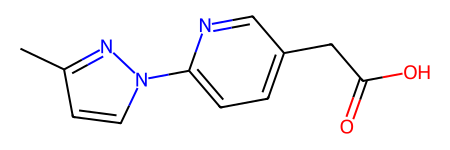

In [285]:
worst_fr9['MOL3'][13876]

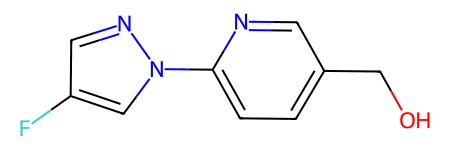

In [294]:
best_fr9['MOL3'][76220]

In [295]:
common_columns = best_fr9.columns.intersection(worst_fr9.columns)

In [303]:
good_bad_fr9 = pd.DataFrame(columns = common_columns)

In [304]:
good_bad_fr9.loc[0] = best_fr9.loc[76220, common_columns]
good_bad_fr9.loc[1] = worst_fr9.loc[13876, common_columns]

In [306]:
mols2grid.display(good_bad_fr9, mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], size=(300,300))

MolGridWidget()

In [311]:
mols2grid.save(good_bad_fr9, output='good_bad_examples_framework9.html', mol_col='MOL3', subset=['ucb 1533', 'prediction 1533', 'variance 1533'], 
               size=(300,300))

MolGridWidget()

## Trying to get more examples per scaffold

In [3]:
def create_murcko_dict(df):
    df['Murcko'] = df['MOL3'].apply(MurckoScaffold.GetScaffoldForMol)
    df['Murcko SMILES'] = df['Murcko'].apply(Chem.MolToSmiles)
    df['Murcko count'] = 0
    murcko_occurence_dict = dict(zip(set(df['Murcko SMILES']), df['Murcko count']))
    for scaff in df['Murcko SMILES'] :
        murcko_occurence_dict[scaff] += 1
    sorted_murcko_dict = sorted(murcko_occurence_dict.items(), key=lambda x: x[1], reverse=True)
    murcko_grid_dict = dict()
    murcko_grid_dict['SMILES'] = [x[0] for x in sorted_murcko_dict]
    murcko_grid_dict['occurences'] = [x[1] for x in sorted_murcko_dict]
    murcko_grid_dict['molecules'] = [Chem.MolFromSmiles(x[0]) for x in sorted_murcko_dict]
    return murcko_grid_dict

In [46]:
best_quin = best[best['scaffold'] == 'quinoleine']

In [14]:
len(best_quin)

2666

In [16]:
worst_quin = worst[worst['scaffold'] == 'quinoleine']

In [19]:
len(worst_quin)

950

In [20]:
murcko_worst_quin = create_murcko_dict(worst_quin)

In [21]:
mols2grid.display(murcko_worst_quin, subset=["img","occurences"], substruct_highlight=True)

MolGridWidget()

In [22]:
murcko_best_quin = create_murcko_dict(best_quin)

In [23]:
mols2grid.display(murcko_best_quin, subset=["img","occurences"], substruct_highlight=True)

MolGridWidget()

In [24]:
murcko_worst_quin['SMILES'][1], murcko_best_quin['SMILES'][3]

('c1ccc(NCc2cccc3ncccc23)nc1', 'c1ccc(NCc2cccc3ncccc23)cc1')

In [109]:
good_examples_quin = best_quin[best_quin['Murcko SMILES'] == 'c1ccc(NCc2cccc3ncccc23)cc1']

In [110]:
bad_examples_quin = worst_quin[worst_quin['Murcko SMILES'] == 'c1ccc(NCc2cccc3ncccc23)nc1']

In [111]:
good_examples_quin['mol'] = (good_examples_quin['L1']+'.'+good_examples_quin['L2']+'.'+good_examples_quin['L3']).apply(Chem.MolFromSmiles)

In [112]:
bad_examples_quin['mol'] = (bad_examples_quin['L1']+'.'+bad_examples_quin['L2']+'.'+bad_examples_quin['L3']).apply(Chem.MolFromSmiles)

In [117]:
best_quin_grid = mols2grid.MolGrid(good_examples_quin, mol_col='mol', size=(300,300))

MolGridWidget()

In [118]:
worst_quin_grid = mols2grid.MolGrid(bad_examples_quin, mol_col='mol', size=(300,300))

MolGridWidget()

In [119]:
display(HTML(f"<h2>Best results</h2>"))
display(best_quin_grid.display(subset=['ucb 1533', 'prediction 1533']))

display(HTML(f"<h2>Worst results</h2>"))
display(worst_quin_grid.display(subset=['ucb 1533', 'prediction 1533']))


In [170]:
best_html = best_quin_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()
worst_html = worst_quin_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()

In [171]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results</title>
</head>
<body>
    <h2>Best results</h2>
    {best_html}
    <h2>Worst results</h2>
    {worst_html}
</body>
</html>
"""

# Save the HTML content to a file
with open("quinoline_good_bad_examples.html", "w") as file:
    file.write(html_content)

# Display the HTML content within the notebook
display(HTML(html_content))

In [120]:
best_fr3 = best[best['scaffold'] == 'framework3']

In [29]:
len(best_fr3)

95246

In [30]:
worst_fr3 = worst[worst['scaffold'] == 'framework3']

In [31]:
len(worst_fr3)

151

In [32]:
murcko_worst_fr3 = create_murcko_dict(worst_fr3)

In [33]:
mols2grid.display(murcko_worst_fr3, subset=['img', 'occurences'])

MolGridWidget()

In [34]:
murcko_best_fr3 = create_murcko_dict(best_fr3)

In [35]:
mols2grid.display(murcko_best_fr3, subset=['img', 'occurences'])

MolGridWidget()

In [39]:
murcko_worst_fr3['SMILES'][14], murcko_best_fr3['SMILES'][11]

('O=c1c2ccccc2ncn1/N=C/c1ccncc1', 'O=c1c2ccccc2ncn1/N=C/c1ccccc1')

In [42]:
mols2grid.display(best_fr3[best_fr3['Murcko SMILES'] == 'O=c1c2ccccc2ncn1/N=C/c1ccccc1'], mol_col='MOL3', subset=['prediction 1533'], size=(200,200))

MolGridWidget()

In [43]:
good_examples_fr3 = best_fr3[best_fr3['Murcko SMILES'] == 'O=c1c2ccccc2ncn1/N=C/c1ccccc1'].iloc[[17,20,31,34,54,63,75,77,86]]

In [45]:
mols2grid.display(worst_fr3[worst_fr3['Murcko SMILES'] == 'O=c1c2ccccc2ncn1N=Cc1ccncc1'], mol_col='MOL3', subset=['prediction 1533'])

MolGridWidget()

In [48]:
bad_examples_fr3 = worst_fr3[worst_fr3['Murcko SMILES'] == 'O=c1c2ccccc2ncn1N=Cc1ccncc1'].iloc[[3,4,7]]

In [105]:
good_examples_fr3['mol'] = (good_examples_fr3['L1']+'.'+good_examples_fr3['L2']+'.'+good_examples_fr3['L3']).apply(Chem.MolFromSmiles)

In [106]:
bad_examples_fr3['mol'] = (bad_examples_fr3['L1']+'.'+bad_examples_fr3['L2']+'.'+bad_examples_fr3['L3']).apply(Chem.MolFromSmiles)

In [121]:
best_fr3_grid = mols2grid.MolGrid(good_examples_fr3, mol_col='mol', size=(300,300))
worst_fr3_grid = mols2grid.MolGrid(bad_examples_fr3, mol_col='mol', size=(300,300))

MolGridWidget()

MolGridWidget()

In [122]:
display(HTML(f"<h2>Best results</h2>"))
display(best_fr3_grid.display(subset=['ucb 1533', 'prediction 1533']))

display(HTML(f"<h2>Worst results</h2>"))
display(worst_fr3_grid.display(subset=['ucb 1533', 'prediction 1533']))


In [168]:
best_html = best_fr3_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()
worst_html = worst_fr3_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()

In [169]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results</title>
</head>
<body>
    <h2>Best results</h2>
    {best_html}
    <h2>Worst results</h2>
    {worst_html}
</body>
</html>
"""

# Save the HTML content to a file
with open("fr3_good_bad_examples.html", "w") as file:
    file.write(html_content)

# Display the HTML content within the notebook
display(HTML(html_content))

In [51]:
print(best['scaffold'].value_counts())

framework3    95246
quinoleine     2666
framework8     1092
framework9      778
framework5      198
framework7       19
bipy              1
Name: scaffold, dtype: int64


In [52]:
print(worst['scaffold'].value_counts())

bipy          42029
framework9    28374
phen          14714
dipyamine      9423
framework6     3754
quinoleine      950
framework5      320
framework8      280
framework3      151
framework7        4
no match          1
Name: scaffold, dtype: int64


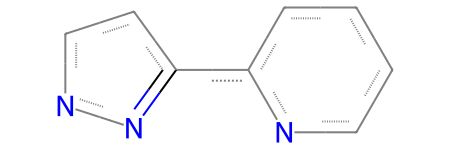

In [53]:
framework5

In [54]:
best_fr5 = best[best['scaffold'] == 'framework5']

In [55]:
worst_fr5 = worst[worst['scaffold'] == 'framework5']

In [59]:
murcko_best_fr5, murcko_worst_fr5 = create_murcko_dict(best_fr5), create_murcko_dict(worst_fr5)

In [60]:
mols2grid.display(murcko_best_fr5, subset=['img', 'occurences'])

MolGridWidget()

In [61]:
mols2grid.display(murcko_worst_fr5, subset=['img', 'occurences'])

MolGridWidget()

In [62]:
murcko_best_fr5['SMILES'][0]

'c1ccc(C2CC(c3ccccn3)=NN2)cc1'

In [63]:
mols2grid.display(best_fr5[best_fr5['Murcko SMILES'] == 'c1ccc(C2CC(c3ccccn3)=NN2)cc1'], mol_col='MOL3', subset=['prediction 1533', 'SMILES'],
                  size=(200,200))

MolGridWidget()

In [64]:
mols2grid.display(best_fr5[best_fr5['Murcko SMILES'] == 'c1ccc(C2CC(c3ccccn3)=NN2c2ccccc2)cc1'].iloc[[0,2,4]], mol_col='MOL3')

MolGridWidget()

In [65]:
best_fr5[best_fr5['Murcko SMILES'] == 'c1ccc(C2CC(c3ccccn3)=NN2)cc1'].iloc[[0,1,2]]

L1                        L2  \
3171  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
3803  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   
3890  Cc1ccc2ccc3ccc(C)nc3c2n1  Cc1ccc2ccc3ccc(C)nc3c2n1   

                                  L3  \
3171  Brc1cccc(C2CC(c3ccccn3)=NN2)c1   
3803  Brc1ccc(C2CC(c3ccccn3)=NN2)cc1   
3890    Brc1ccccc1C1CC(c2ccccn2)=NN1   

                                            Descriptors  prediction 1533  \
3171  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.157701   
3803  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.145878   
3890  [ 2.55139473e+00  6.25945478e+02  1.11209559e+...         6.142449   

      variance 1533  ucb 1533  \
3171       4.891777  8.811784   
3803       4.888918  8.799186   
3890       4.895552  8.797556   

                                                   MOL3    scaffold  \
3171  <rdkit.Chem.rdchem.Mol object at 0x00000170594...  framework5   
3803  <rdkit.Chem.rdchem.Mol object at 0x00000170594...  framework5   
3890  <rdkit.Chem.rdchem.Mol object at 0x00000170594...  framework5   

                                                 Murcko  \
3171  <rdkit.Chem.rdchem.Mol object at 0x00000172BB5...   
3803  <rdkit.Chem.rdchem.Mol object at 0x00000172BB5...   
3890  <rdkit.Chem.rdchem.Mol object at 0x00000172BB5...   

                     Murcko SMILES  Murcko count  
3171  c1ccc(C2CC(c3ccccn3)=NN2)cc1             0  
3803  c1ccc(C2CC(c3ccccn3)=NN2)cc1             0  
3890  c1ccc(C2CC(c3ccccn3)=NN2)cc1             0

In [76]:
good_examples_fr5 = pd.concat([best_fr5[best_fr5['Murcko SMILES'] == 'c1ccc(C2CC(c3ccccn3)=NN2)cc1'].iloc[[0,1,2]], 
                                best_fr5[best_fr5['Murcko SMILES'] == 'c1ccc(C2CC(c3ccccn3)=NN2c2ccccc2)cc1'].iloc[[0,2,4]]])

In [77]:
murcko_worst_fr5['SMILES'][1]

'O=C(c1ccncc1)N1N=C(c2ccccn2)CC1c1ccccc1'

In [78]:
mols2grid.display(worst_fr5[worst_fr5['Murcko SMILES'] == 'O=C(c1ccncc1)N1N=C(c2ccccn2)CC1c1ccccc1'], mol_col='MOL3', subset=['prediction 1533'],
                 size=(200,200))

MolGridWidget()

In [79]:
bad_examples_fr5 = worst_fr5[worst_fr5['Murcko SMILES'] == 'O=C(c1ccncc1)N1N=C(c2ccccn2)CC1c1ccccc1'].iloc[[0,6,9,11,12]]

In [123]:
good_examples_fr5['mol'] = (good_examples_fr5['L1']+'.'+good_examples_fr5['L2']+'.'+good_examples_fr5['L3']).apply(Chem.MolFromSmiles)

In [124]:
bad_examples_fr5['mol'] = (bad_examples_fr5['L1']+'.'+bad_examples_fr5['L2']+'.'+bad_examples_fr5['L3']).apply(Chem.MolFromSmiles)

In [129]:
best_fr5_grid = mols2grid.MolGrid(good_examples_fr5, mol_col='mol', size=(300,300))
worst_fr5_grid = mols2grid.MolGrid(bad_examples_fr5, mol_col='mol', size=(300,300))

MolGridWidget()

MolGridWidget()

In [130]:
display(HTML(f"<h2>Best results</h2>"))
display(best_fr5_grid.display(subset=['ucb 1533', 'prediction 1533']))

display(HTML(f"<h2>Worst results</h2>"))
display(worst_fr5_grid.display(subset=['ucb 1533', 'prediction 1533']))


In [162]:
best_html = best_fr5_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()
worst_html = worst_fr5_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()

In [163]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results</title>
</head>
<body>
    <h2>Best results</h2>
    {best_html}
    <h2>Worst results</h2>
    {worst_html}
</body>
</html>
"""

# Save the HTML content to a file
with open("fr5_good_bad_results.html", "w") as file:
    file.write(html_content)

In [82]:
best_fr8 = best[best['scaffold'] == 'framework8']

In [83]:
worst_fr8 = worst[worst['scaffold'] == 'framework8']

In [84]:
murcko_best_fr8, murcko_worst_fr8 = create_murcko_dict(best_fr8), create_murcko_dict(worst_fr8)

In [85]:
mols2grid.display(murcko_best_fr8, subset=['img', 'occurences']) 

MolGridWidget()

In [86]:
mols2grid.display(murcko_worst_fr8, subset=['img', 'occurences']) 

MolGridWidget()

In [87]:
murcko_best_fr8['SMILES'][5]

'c1ccc(C2=NN(c3ccccn3)C(c3ccccc3)C2)cc1'

In [88]:
murcko_worst_fr8['SMILES'][11]

'C1=NN(c2ccccn2)C(Cc2ccccn2)C1'

In [89]:
mols2grid.display(best_fr8[best_fr8['Murcko SMILES'] == 'c1ccc(C2=NN(c3ccccn3)C(c3ccccc3)C2)cc1'], mol_col='MOL3', subset=['prediction 1533'],
                  size=(200,200))

MolGridWidget()

In [90]:
good_examples_fr8 = best_fr8[best_fr8['Murcko SMILES'] == 'c1ccc(C2=NN(c3ccccn3)C(c3ccccc3)C2)cc1'].iloc[[2,4,6,7,8,9]]

In [91]:
mols2grid.display(worst_fr8[worst_fr8['Murcko SMILES'] == 'c1ccc(C2=NN(c3ccccn3)C(c3ccccn3)C2)cc1'], mol_col='MOL3',
                  subset=['prediction 1533'], size=(200,200))

MolGridWidget()

In [92]:
bad_examples_fr8 = worst_fr8[worst_fr8['Murcko SMILES'] == 'c1ccc(C2=NN(c3ccccn3)C(c3ccccn3)C2)cc1']

In [131]:
good_examples_fr8['mol'] = (good_examples_fr8['L1']+'.'+good_examples_fr8['L2']+'.'+good_examples_fr8['L3']).apply(Chem.MolFromSmiles)

In [132]:
bad_examples_fr8['mol'] = (bad_examples_fr8['L1']+'.'+bad_examples_fr8['L2']+'.'+bad_examples_fr8['L3']).apply(Chem.MolFromSmiles)

In [137]:
best_fr8_grid = mols2grid.MolGrid(good_examples_fr8, mol_col='mol', size=(300,300))
worst_fr8_grid = mols2grid.MolGrid(bad_examples_fr8, mol_col='mol', size=(300,300))

MolGridWidget()

MolGridWidget()

In [138]:
display(HTML(f"<h2>Best results</h2>"))
display(best_fr8_grid.display(subset=['ucb 1533', 'prediction 1533']))

display(HTML(f"<h2>Worst results</h2>"))
display(worst_fr8_grid.display(subset=['ucb 1533', 'prediction 1533']))


In [164]:
best_html = best_fr8_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()
worst_html = worst_fr8_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()

In [165]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results</title>
</head>
<body>
    <h2>Best results</h2>
    {best_html}
    <h2>Worst results</h2>
    {worst_html}
</body>
</html>
"""

# Save the HTML content to a file
with open("fr8_good_bad_examples.html", "w") as file:
    file.write(html_content)

In [95]:
best_fr9, worst_fr9 = best[best['scaffold'] == 'framework9'], worst[worst['scaffold'] == 'framework9']

In [96]:
murcko_best_fr9, murcko_worst_fr9 = create_murcko_dict(best_fr9), create_murcko_dict(worst_fr9)

In [97]:
mols2grid.display(murcko_best_fr9, subset=['img', 'occurences'])

MolGridWidget()

In [98]:
mols2grid.display(murcko_worst_fr9, subset=['img', 'occurences'])

MolGridWidget()

In [99]:
murcko_best_fr9['SMILES'][3]

'c1ccc(-c2ccn(-c3ccccn3)n2)cc1'

In [100]:
mols2grid.display(best_fr9[best_fr9['Murcko SMILES'] == 'c1ccc(-c2ccn(-c3ccccn3)n2)cc1'], mol_col='MOL3',
                  subset=['prediction 1533'], size=(200,200))

MolGridWidget()

In [101]:
mols2grid.display(worst_fr9[worst_fr9['Murcko SMILES'] == 'c1ccc(-c2ccn(-c3ccccn3)n2)cc1'], mol_col='MOL3',
                  subset=['prediction 1533'], size=(200,200))

MolGridWidget()

In [102]:
bad_examples_fr9 = worst_fr9[worst_fr9['Murcko SMILES'] == 'c1ccc(-c2ccn(-c3ccccn3)n2)cc1'].iloc[[22,25,40,51,74]]
good_examples_fr9 = best_fr9[best_fr9['Murcko SMILES'] == 'c1ccc(-c2ccn(-c3ccccn3)n2)cc1'].iloc[[1,2,3]]

In [139]:
good_examples_fr9['mol'] = (good_examples_fr9['L1']+'.'+good_examples_fr9['L2']+'.'+good_examples_fr9['L3']).apply(Chem.MolFromSmiles)

In [140]:
bad_examples_fr9['mol'] = (bad_examples_fr9['L1']+'.'+bad_examples_fr9['L2']+'.'+bad_examples_fr9['L3']).apply(Chem.MolFromSmiles)

In [146]:
best_fr9_grid = mols2grid.MolGrid(good_examples_fr9, mol_col='mol', size=(300,300))
worst_fr9_grid = mols2grid.MolGrid(bad_examples_fr9, mol_col='mol', size=(300,300))


MolGridWidget()

MolGridWidget()

In [147]:
display(HTML(f"<h2>Best results</h2>"))
display(best_fr9_grid.display(subset=['ucb 1533', 'prediction 1533']))

display(HTML(f"<h2>Worst results</h2>"))
display(worst_fr9_grid.display(subset=['ucb 1533', 'prediction 1533']))


In [166]:
best_html = best_fr9_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()
worst_html = worst_fr9_grid.display(subset=['ucb 1533', 'prediction 1533'])._repr_html_()

In [167]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Results</title>
</head>
<body>
    <h2>Best results</h2>
    {best_html}
    <h2>Worst results</h2>
    {worst_html}
</body>
</html>
"""

# Save the HTML content to a file
with open("fr9_good_bad_examples.html", "w") as file:
    file.write(html_content)